# Transcription factor binding analysis with convolutional networks

In this notebook, we will walk through a simple tensorflow example of how to build, train, and evaluate a convolutional neural network for a common supervised classification learning task of predicting whether or not a TF binds to a given sequence. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

## Intro to Convolutional Neural Networks

Convolutional neural networks (CNNs) are the current state-of-the-art model architecture for image classification tasks. Typically, a CNN is composed of a stack of convolutional modules that perform feature extraction. Each module consists of a convolutional layer followed by a pooling layer. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single node for prediction in the model.

CNNs contains three main components:

* Convolutional layers:  apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.

* Pooling layers: downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.

* Dense (fully connected) layers, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

For more details on CNNs:
https://cs231n.github.io/convolutional-networks/


## Dataset overview 

Here, we will employ a CNN model to experimental ChIP-seq data for CTCF, a transciption factor that is known to bind to DNA and help form loops.  The CTCF conservative narrow peaks were downloaded from the ENCODE database:
https://www.encodeproject.org/experiments/ENCSR000BIE/

!wget https://www.encodeproject.org/files/ENCFF252PLM/@@download/ENCFF252PLM.bed.gz

Supervised learning tries to find patterns in the data that help to discriminate the two classes.  Thus, we need a set of background sequences which don't have a CHIP-seq peak. Because the accessibility of DNA is different across cell-types, randomly choosing sequences throughout the genome may include a CTCF motif. So we chose to use background sequences that were generated by performing a di-nucleotide shuffle of the positive sequences. 

The peaks were processed with a script (process_chip.py), whose steps include:
    1. enforce a constant window about each peak (window size = 100 nts)
    2. employ bedtools to extract sequences from GRC38 reference genome
    3. filter sequences which contain `N' characters
    4. convert sequences into a one-hot representation
    5. generate background sequences by performing a dinucleotide shuffle using meme
    6. combine and shuffles positive and negative sequences
    7. create a label vector with either a one for sequences that has a ChIP-seq peak and a zero for di-nuc shuffled sequences
    8. split the dataset into a training set, validation set, and test set
    9. save dataset to a hdf5 file
    

After processing, this dataset includes 72,769 training sequences, 10,396 validation sequences, and 20,792 test sequences.  Each sequence is 100 nts long taken about the center of a CHIP-seq peak  called across two replicates. The positive sequences have a label of 1, while the background sequences have a label of 0 (Y_train).  

Let's load the data:

In [2]:
# path to dataset 
data_file_path = '../data/CTCF_100.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

print(X_train.shape)

(72769, 4, 100)


Note that the training sequences (X_train) have a shape of [72769, 4, 200].  Although tensorflow supports a 1D convolution function, tensorflow was designed with 2D images in mind, so there is way better support for the 2D functions.  We can use these 2D functions by adding another 'ornamental' dimension.  

In [3]:
# add another dimension to make it a 4D tensor and transpose dimensions 
X_train = np.expand_dims(X_train, axis=3).transpose([0, 2, 3, 1])
X_test = np.expand_dims(X_test, axis=3).transpose([0, 2, 3, 1])
X_valid = np.expand_dims(X_valid, axis=3).transpose([0, 2, 3, 1])

num_data, seq_length, _, dims = X_train.shape

The 1 essentially makes the 2D convolution function act as a 1D convolution.  We also transpose the dimensions to match the inuts for the 2D convlution functions which take: (batch size, sequence length, 1, nucleotide channels). 

# Our convolutional neural network model 

Our model will be similar to DeepBind: an input layer, one convolutional layer, one max-pooling layer, one fully-connected hidden layer, and a fully-connected output layer.  A brief explanation of each layer will be provided as we build up this graph.

#### Reset graphs 

First, we need to reset the default graph to start with a fresh canvas.  Sometimes, you can have disjoint graphs when you forget that you created variables and ops, but then removed them without resetting the graph. 

In [4]:
tf.reset_default_graph()


tf.set_random_seed(247)  # for repeatability

#### Input layer

Next, we need to establish an input layer where we can feed in data.  In tensorflow, this is achieved with placeholders.  Placeholders allow you to feed in data into a tensorflow graph at run time.  All you need to do is set the shape of the placeholder and the data type.  

In [5]:
# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

A shape of None means that it is variable.  This is useful so that we can change the batch size to whatever we want during run time.
 
 
#### Weight Initialization

To create our model, we need to instantiate tensorflow variables.  To do so, we need to initialize them. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. In practice, weights are typically initialized by either Glorot-inits or He-inits, while biases can be initialized with a constant value.  Since we're going to need to create a lot of weights and biases, let's create two handy functions: He-inits for the parameters and constant-inits for the bias terms.

In [6]:
# functions for initializations also known as inits
def he_init(shape, fan_in):
    """He inits are designed for neural networks that employ ReLU activations."""
    # fan_in is the number of neurons going into the layer
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

#### Convolutional layer
    
Tensorflow's tf.nn includes a nice 2D convolution operation for us (tf.nn.conv2d) with arguments::
* inputs 
* filter   
* strides  
* padding
                      
                      
The inputs argument specifies our input tensor, which must have the shape [batch_size, image_width, image_height, channels]. 

The filters argument specifies the tensorflow variables that will be used to scan the inputs. 

The padding argument specifies one of two enumerated values: VALID (default) or SAME. To specify that the output tensor should have the same width and height values as the input tensor, we set padding=SAME here, which instructs TensorFlow to add 0 values to the edges of the input tensor to preserve width and height of 28. (Without padding, a 5x5 convolution over a 28x28 tensor will produce a 24x24 tensor, as there are 24x24 locations to extract a 5x5 tile from a 28x28 grid.)

The strides argument specifies the step size during the scanning of each filter. A stride of 1 means that every position is scanned. A stride of 2 means that every other position is scanned.   

In [7]:
# build the first convolutional layer
num_filters = 16
filter_size = 19
strides = 1

# create variable for the convolutional filters
shape = [filter_size, 1, dims, num_filters] # shape = [filter_size, 1, incoming dim, num_filters]
W_inits = he_init(shape=shape, fan_in=dims*seq_length)  # create He-inits with the right shape
W1 = tf.Variable(W_inits, name='W1', trainable=True)    # create variable initialized with He-inits

# perform convolution
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1,                   # initialized filter variable
                      strides=[1, strides, 1, 1],  # strides performs the step size of the convolution 
                      padding='SAME')              # padding is either 'SAME' or 'VALID'

Since the padding is the same, the length of the sequence will remain the same.  So the output will be a shape of [None, 100, 1, num_filters].

Now we can add a bias term for each filter and perform a non-linear activation with a rectified linear unit. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". 

In [8]:
# initialize bias
b_inits = const_init(shape=[num_filters], value=0.01)  

# create bias variable
b1 = tf.Variable(b_inits, name='b1')   # trainable=True is default 

# add bias term to the output of the convolutional scans
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform non-linear activation
conv_1_active = tf.nn.relu(conv_1_bias)

#### Max-pool layer

Max-pooling is a way to downsample the data over a window size set by ksize.  The strides of max pooling sets how many steps to take to create a new window.  If the strides is set to the ksize, this creates non-overlapping windows. Here, we will downsample the 1st convolutional layer scans by non-overlapping windows of size 25.  This will create a shape of [None, 4, 1, num_filters].

In [9]:
# downsample data with max-pooling
pool_size = 25
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1),     # pool size
                             strides=(1,pool_size,1,1),   # strides sets the step size of the windows
                             padding='SAME')              # padding is either 'SAME' or 'VALID'

#### fully-connected hidden layer

Fully-connected (dense) layers can be accomplished with a single matrix multiplication.  To do this, we need to reshape the 4D tensor into a 2D tensor: shape=[None, 4*num_filters]

In [10]:
# get number of input neurons
num_incoming = np.prod(conv_1_pool.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_pool, shape=(-1,num_incoming))

Now we can initialize a weight matrix which captures all possible connections between the output of the max-pooled layer and each hidden neuron in the fully-connected layer.  

In [11]:
# build a fully-connected layer (also known as a dense layer)
num_units = 32

# create weight and bias variables
W2 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')

# calculate the matrix multiplication
dense_2 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_2_bias = tf.nn.bias_add(dense_2, b2)

# perform activation
dense_2_active = tf.nn.relu(dense_2_bias)

#### fully-connected output layer

The output layer is a linear classifier model.  So, the number of predictions we want to make is the number of output neurons we need to create.  Here that number is one, because we are only predicting whether or not a sequence is associated with a CTCF ChIP-seq peak.  If there were more labels, all we have to do is set the 1 to some other value.  Note that the activation is dependent on what you are trying to predict.  For instance, a regression can be achieved by a simple linear model, without any activation; a binary classificaiton can be achieved with a sigmoid activation, a multi-class prediction of the most likely class can be achieved with a softmax activation, etc...  Here we are performing a single-class binary classificaiton, so we will employ sigmoid activations on our output neuron.

In [12]:
num_outputs = 1

# create weight and bias variables
W3 = tf.Variable(he_init(shape=[num_units, num_outputs], fan_in=num_units), name='W3')
b3 = tf.Variable(const_init(shape=[num_outputs], value=0.01), name='b3')

# build a fully-connected layer (also known as a dense layer)
dense_3 = tf.matmul(dense_2_active, W3)

# add bias term
dense_3_bias = tf.nn.bias_add(dense_3, b3)

# make binary predictions
predictions = tf.nn.sigmoid(dense_3_bias)

## build loss function

For both training and evaluation, we need to define a loss function that measures how closely the model's predictions match the target classes. This is usually a log-likelihood function for supervised learning.  The log-likelihood for a binary classification is the binary cross-entropy loss function.  Since we need to compare our predictions with the labels, we have to be able to feed the labels into the graph.  So, let's create a placeholder for the labels.  Then, we can calculate the binary cross-entropy loss:

$\mathcal{L} = \sum_i y_i \log(p_i) + (1-y_i)\log(1-p_i)$

Since the log of smaller numbers grows exponentially, we can safeguard against numerical overflow by adding a small number inside the log. 

In [13]:
# create placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
eps = 1e-10
binary_cross_entropy = targets*tf.log(predictions + eps) + (1 - targets)*tf.log(1 - predictions + eps)

# let's calculate the average across classes, i.e. tf.reduce_sum,
# Note that this is not necessary for this dataset (1 class)
log_likelihood = tf.reduce_sum(binary_cross_entropy, axis=1)

# let's calculate the mean negative log-likelihood within a mini-batch
loss_function = tf.reduce_mean(-log_likelihood)

## build optimizer

Now that we have our loss function established, we need to be able to calculate the gradients of the loss function with respect to the parameters of the model, which is efficiently accomplished with backpropagation.  Then, we can update the weights with a scaled gradients, which is knownas gradient descent learning. Fortunately, tensorflow provides a nice wrapper to perform all of this with the tf.train API.  Within tf.train are numerous types of gradient descent optimizers, including traditional stochastic gradient descent (SGD), SGD with momentum, ADAGRAD, RMSPROP, ADAM, plus more.  

Here, we will use sgd with momentum:

In [14]:
# setup optimizer
optimizer = tf.train.MomentumOptimizer(learning_rate=0.001, 
                                       momentum=0.9)

# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# create op to calculate derivatives and update parameters
train_step = optimizer.minimize(loss_function, var_list=trainable_vars)

The returned operation train_step, when run, will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running train_step.


# create a session

Now that we have constructed the graph, the loss is defined, and we have created an optimizer, we can train the model by executing the train_step in a session.  

In [15]:
sess = tf.Session()

## Initialize all variables

We have to initialize all variables before executing any graph nodes. 

In [16]:
sess.run(tf.global_variables_initializer())

After initializing the variables with the session, training may begin.


## train the neural network

We want to train our CNN model with mini-batch stochastic gradient descent.  So, we need a way to generate mini-batches of data. An effective strategy for training is to shuffle the dataset between each epoch. So, let's define a function to generate shuffled mini-batches. 

In [17]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)

Now let's run our training loop.  

In [18]:
# training parameters
num_epochs = 10        # maximum number of epochs
batch_size = 100         # mini-batch size for a parameter update
num_train_batches = X_train.shape[0] // batch_size

# training loop
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        
        # get a new mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run(fetches=[loss_function, train_step], 
                           feed_dict={inputs: x_batch, targets: y_batch})
        # Because there are two values to fetch, sess.run() returns a tuple 
        # with two items. Each Tensor in the list of values to fetch corresponds 
        # to a numpy array in the returned tuple, filled with the value of that 
        # tensor during this step of training. Since train_op is an Operation with 
        # no output value, the corresponding element in the returned tuple is None 
        # and, thus, discarded. 
        
        # calculate running sum of loss
        train_loss += loss
        
    # calculate loss and predictions on validation set
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, targets: Y_valid})

    # calculate performance metrics
    fpr, tpr, thresholds = roc_curve(Y_valid[:,0], valid_predict[:,0])
    score = auc(fpr, tpr)

    # print progress
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation AU-ROC:\t\t{:.6f}".format(score))

Epoch 1 of 10
  training loss:		0.688529
  validation loss:		0.669319
  validation AU-ROC:		0.662884
Epoch 2 of 10
  training loss:		0.612456
  validation loss:		0.527142
  validation AU-ROC:		0.859792
Epoch 3 of 10
  training loss:		0.460975
  validation loss:		0.415961
  validation AU-ROC:		0.896334
Epoch 4 of 10
  training loss:		0.393673
  validation loss:		0.381984
  validation AU-ROC:		0.911438
Epoch 5 of 10
  training loss:		0.363997
  validation loss:		0.361983
  validation AU-ROC:		0.919827
Epoch 6 of 10
  training loss:		0.345564
  validation loss:		0.346749
  validation AU-ROC:		0.925857
Epoch 7 of 10
  training loss:		0.331975
  validation loss:		0.338015
  validation AU-ROC:		0.931002
Epoch 8 of 10
  training loss:		0.321293
  validation loss:		0.326085
  validation AU-ROC:		0.935299
Epoch 9 of 10
  training loss:		0.311679
  validation loss:		0.318340
  validation AU-ROC:		0.938923
Epoch 10 of 10
  training loss:		0.302471
  validation loss:		0.307655
  validation AU-ROC:

In [19]:
sess.close()



# Train neural network with early stopping  -- saving parameters along the way

One major drawback to the way we were training previously is that we have to determine an arbitrary number of epochs to train.  At some point, the nerual network can start to overfit, leading to a poorer generalization performance.  One way around this is to stop training when the validation performance doesn't improve after a set number of epochs, a powerful regularization technique known as early stopping. The set number of epochs to wait is known as the patience.  However, during the time that we wait for the patience, a model can start to overfit.  So, we need a way to save the model parameters only when the performance on the validation set is improved, i.e. lower loss value.  Then, after training is complete, we can reload the 'optimal' model parameters.  We can save model parameters with:

saver = tf.train.Saver()

saver.save(sess, FLAGS.train_dir, global_step=step)

At some later point in the future, we can restore the model parameters with:

saver.restore(sess, FLAGS.train_dir)

Also, the previous model was just a simple CNN model.  Let's build the same model with some tweaks to improve its performance. To reduce overfitting, we will apply dropout after each hidden layer.  We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.  We can also apply L2-regularization.

In [20]:
# reset graphs --> this is necessary if you accidentally build multiple graphs, 
#                  then the other graphs will also save as will the other graph's parameters. 
tf.reset_default_graph()
tf.set_random_seed(247)

# functions for initializations also known as inits
def he_init(shape, fan_in):
    """He inits are designed for neural networks that employ ReLU activations."""
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# build the first convolutional layer
num_filters = 16
filter_size = 19
strides = 1
W1 = tf.Variable(he_init(shape=[filter_size, 1, dims, num_filters], fan_in=dims*seq_length), name='W1')
b1 = tf.Variable(const_init(shape=[num_filters], value=0.01), name='b1')
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1, 
                      strides=[1, strides, 1, 1], 
                      padding='SAME')

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform activation
conv_1_active = tf.nn.relu(conv_1_bias)

# downsample data with max-pooling
pool_size = 25
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1), 
                             strides=(1,pool_size,1,1), 
                             padding='SAME')

# add dropout -- note that keep prob is a placeholder.  
#This allows us to set different levels of dropout during training and testing
keep_prob_conv = tf.placeholder(tf.float32, name='keep_prob_conv')
conv_1_dropout = tf.nn.dropout(conv_1_pool, keep_prob=keep_prob_conv)

# get number of input neurons
num_incoming = np.prod(conv_1_dropout.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_dropout, shape=(-1,num_incoming))

# build a fully-connected layer (also known as a dense layer)
num_units = 64
W2 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_1 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b2)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)

# create a second keep_prob placeholder for dense layers
keep_prob_dense = tf.placeholder(tf.float32, name='keep_prob_dense')
dense_1_active_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob_dense)

# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1], fan_in=num_units), name='W3')
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_2 = tf.matmul(dense_1_active_dropout, W3)

# add bias term
dense_2_bias = tf.nn.bias_add(dense_2, b3)

# make binary predictions
predictions = tf.nn.sigmoid(dense_2_bias)


# calculate loss with L2-regularization and build an optimizer

In [21]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
eps = 1e-10
binary_cross_entropy = targets*tf.log(predictions + eps) + (1 - targets)*tf.log(1 - predictions + eps)
loss_function = tf.reduce_mean(-tf.reduce_sum(binary_cross_entropy, axis=1))
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# flatten and concatenate all parameters for L2/L1 regularization
all_params = []
for param in trainable_vars:
    all_params = tf.concat([all_params, tf.reshape(param, [-1,])], axis=0)
    
# calculate L2 regularization
l2_strength = 1e-6
loss_function += tf.reduce_sum(tf.square(all_params))*l2_strength

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
train_step = optimizer.minimize(loss_function, var_list=trainable_vars)

In [22]:
# start setssion
sess = tf.Session()

# initialize variables
sess.run(tf.global_variables_initializer())

In [23]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)
        
        
# path to save results
save_path = '../results/CTCF'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'simple_cnn_tf')
    
    
num_epochs = 50        # maximum number of epochs
batch_size = 100       # mini-batch size for a parameter update
patience = 5           # number of epochs to wait for a lower validation loss to be found. 
num_train_batches = X_train.shape[0] // batch_size

# training loop
wait = 0
min_loss = 1e10
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, train_step], 
                           feed_dict={inputs: x_batch, 
                                      targets: y_batch, 
                                      keep_prob_conv: 0.9, 
                                      keep_prob_dense: 0.6}
                          )
        train_loss += loss
        
    # calculate loss and predictions on validation set
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, 
                                                    targets: Y_valid, 
                                                    keep_prob_conv: 1.0, 
                                                    keep_prob_dense: 1.0}
                                        )

    # calculate performance metrics
    fpr, tpr, thresholds = roc_curve(Y_valid[:,0], valid_predict[:,0])
    score = auc(fpr, tpr)

    # print progress
    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation AU-ROC:\t\t{:.6f}".format(score))
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            print("Patience ran out... early stopping!")
            break


Epoch 1 of 50
  training loss:		0.681279
  validation loss:		0.583065
  validation AU-ROC:		0.830517
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_tf
Epoch 2 of 50
  training loss:		0.468438
  validation loss:		0.356168
  validation AU-ROC:		0.927065
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_tf
Epoch 3 of 50
  training loss:		0.353301
  validation loss:		0.307239
  validation AU-ROC:		0.943389
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_tf
Epoch 4 of 50
  training loss:		0.320125
  validation loss:		0.287606
  validation AU-ROC:		0.950535
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_tf
Epoch 5 of 50
  training loss:		0.299811
  validation loss:		0.271004
  validation AU-ROC:		0.954720
  Lower validation loss found. Saving parameters to: ../results/CTCF/simple_cnn_tf
Epoch 6 of 50
  training loss:		0.288328
  validation loss:		0.262281
  validati

 let's close the session, so we can walk through an example of how to load the parameters

In [24]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# Evaluating a trained model

#### we can restore the parameters to our graph

In [25]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../results/CTCF'
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../results/CTCF/simple_cnn_rnacompete


#### Now let's test our trained model

  test loss:		0.202517
  test AU-ROC:		0.974555


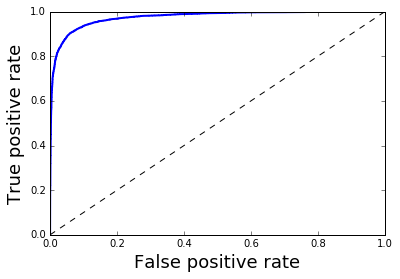

In [26]:
# test model
test_loss, test_predict = sess.run([loss_function, predictions], 
                                     feed_dict={inputs: X_test, 
                                                targets: Y_test, 
                                                keep_prob_conv: 1.0, 
                                                keep_prob_dense: 1.0})

# calculate performance metrics
fpr, tpr, thresholds = roc_curve(Y_test[:,0], test_predict[:,0])
score = auc(fpr, tpr)

print("  test loss:\t\t{:.6f}".format(test_loss))
print("  test AU-ROC:\t\t{:.6f}".format(score))

fig = plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], '--k')
plt.xlabel('False positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.xlim([0,1])
plt.ylim([0,1]);

#### Let's visualize first convolutional layer filters

In [27]:
# get the convolutional filters
filters = sess.run(W1)

# reshape them so that we can visualize them easier
filters = np.squeeze(filters).transpose([2,1,0])

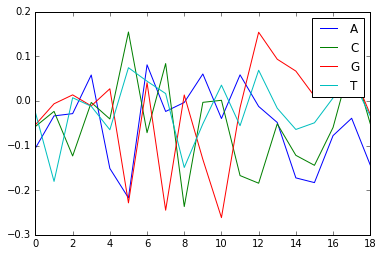

In [28]:
plt.figure()
plt.plot(filters[11].T)
plt.legend(['A', 'C', 'G', 'T'])

Plotting the filters is pretty difficult to interpret.  I've included some plotting functions in impress.py.  Lets use impress to normalize individual filters into a PWM and plot it as a sequence logo.  

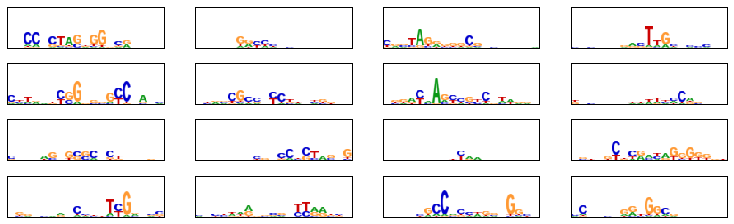

In [29]:
import matplotlib as mpl
import impress

num_filters = filters.shape[0]
grid = mpl.gridspec.GridSpec(4, 4)
grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2)
fig = plt.figure(figsize=(100,30));
for i in range(num_filters):
    plt.subplot(grid[i]);
    norm_filter = impress.normalize_pwm(filters[i], factor=3)
    logo = impress.seq_logo(norm_filter, height=25, nt_width=10)
    plt.imshow(logo, interpolation='none')
    plt.yticks([])
    plt.xticks([])
    

#### Let's generate a saliency map

To calculate a saliency map, we need to calculate the derivative of the output neuron with respect to the inputs.  Luckily, tensorflow makes this easy because it calculates gradients using automatic differentiation.  We can calculate the gradient with the function tf.gradients.  This method constructs partial derivatives of ys w.r.t. x in xs. ys and xs are each a Tensor or a list of tensors. 

tf.gradients(
    ys,
    xs,
    grad_ys=None,
    name='gradients',
    colocate_gradients_with_ops=False,
    gate_gradients=False,
    aggregation_method=None,
    stop_gradients=None
)

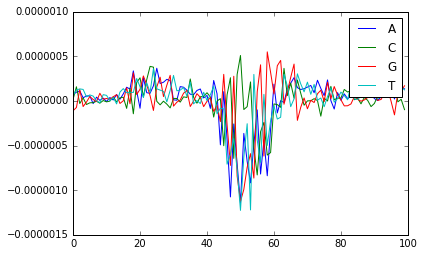

In [30]:
# let's get a sorted list of the highest predicted sequences
max_index = np.argsort(test_predict[:,0])[::-1]

# get a sequence from the list
index = 3
X = np.expand_dims(X_test[max_index[index]], axis=0)

# calculate the gradients to the inputs
grad_to_inputs = tf.gradients(ys=predictions, xs=inputs)

# run the session to calculate the saliency map for a given sequence X
backprop_saliency = sess.run(grad_to_inputs, feed_dict={inputs: X, 
                                                        keep_prob_conv: 1.0, 
                                                        keep_prob_dense: 1.0})

# plot 
plt.plot(np.squeeze(backprop_saliency[0]))
plt.legend(['A','C','G','T']);

I've provided a visualization function to normalize the saliency map to be similar to a PWM and a function to plot a PWM as a sequence logo within the impress module.  

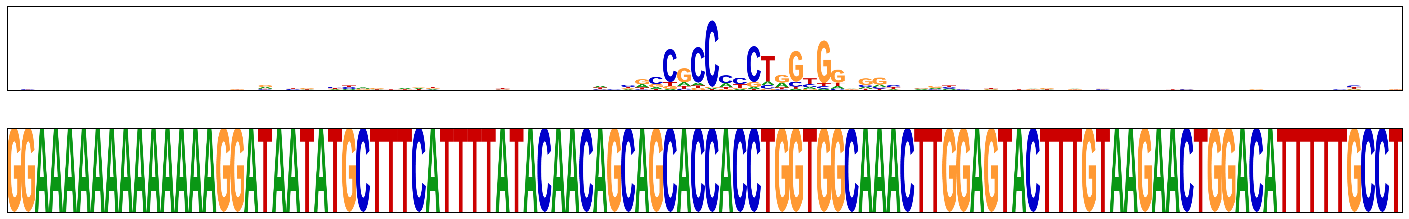

In [31]:
import impress

# filter and normalize saliency map 
norm_saliency = impress.normalize_pwm(np.squeeze(backprop_saliency[0]).T, factor=3)

# generate sequence logo
logo = impress.seq_logo(norm_saliency, height=150, nt_width=50, norm=0)

seq = impress.seq_logo(np.squeeze(X).T, height=150, nt_width=50, norm=0)

# plot sequence logo
plt.figure(figsize=(25,4))
plt.subplot(2,1,1)
plt.imshow(logo)
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.imshow(seq)
plt.xticks([])
plt.yticks([]);

# Where to go from here

###  official tutorials

https://www.tensorflow.org/tutorials/


### lower-level APIs

https://www.tensorflow.org/api_docs/python/tf/nn


### Layers 
    
https://www.tensorflow.org/api_docs/python/tf/layers
  
* tf.nn.layers.conv2d()
* tf.nn.layers.dense
* tf.nn.layers.dropout
* tf.nn.layers.max_pooling2d
* tf.nn.layers.batch_normalization


### alternative 

* tf.contrib.layers
* tf.keras.layers